#Image classification with Custom fastai Resnet34 



Check GPU

In [1]:
!nvidia-smi

Wed May  5 13:11:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install fastai dependencies

In [2]:
!pip install fastai
from fastai.vision import *

Download dataset from personal Mediafire

In [3]:
!curl -L "https://api.jl-workshop.com/v2/csdlg/download?h=03594e7c2e&url=https%3A%2F%2Fwww.mediafire.com%2Ffile%2Fey8m06aagok7umn%2FDataset_split_70.zip%2Ffile" > dataset.zip; unzip dataset.zip; rm dataset.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0    718      0 --:--:-- --:--:-- --:--:--   718
100   119  100   119    0     0    115      0  0:00:01  0:00:01 --:--:--     0
100 7466k  100 7466k    0     0   891k      0  0:00:08  0:00:08 --:--:-- 1284k
Archive:  dataset.zip
   creating: test/
   creating: test/Galaxies/
  inflating: test/Galaxies/178491main_sig07-009-516_jpg.rf.ee2a15076e9c78d6c92f8c342e2fc447.jpg  
  inflating: test/Galaxies/55374a06aa833646c50c52b05661460e_jpg.rf.34473882182d1219a502d8d6abb43e68.jpg  
  inflating: test/Galaxies/839_jpg.rf.e41fc0d6b9b466e225ae472a82bfdf10.jpg  
  inflating: test/Galaxies/heic1709a_jpg.rf.a3a580c2bc853f841b27050dac1fbd36.jpg  
  inflating: test/Galaxies/m81-print_jpg.rf.b6902dfb0911cf911611f1196cee8ce0.jpg  
  inflating: test/Galaxies/opo9941a_jpg.rf.31afdc60f5bd1d244f87336eb1cf3ad5.jpg  
  infla

Build fastai dataset loader. 
- fastai automatically factors the ./train and ./valid folders into seperate datasets
- get_transform() implement diffferent type of data augmentation (flip, zoom, rotate,  ecc...)


In [4]:
np.random.seed(42)
path = Path('/content/')
data = ImageDataBunch.from_folder(path, size=224, ds_tfms=get_transforms(), num_workers=2).normalize(imagenet_stats)

Double check the data classes

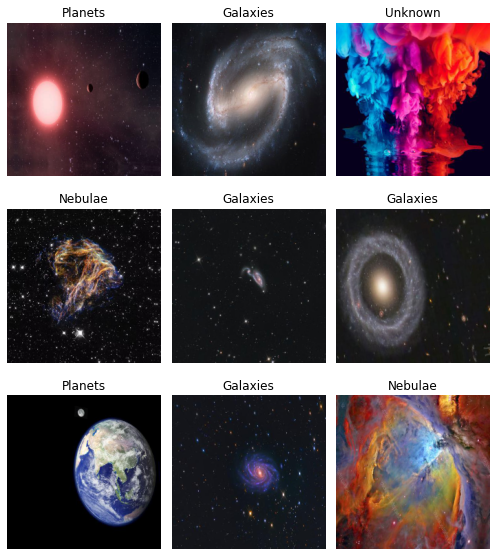

In [5]:
data.classes
data.show_batch(rows=3, figsize=(7, 8))

Set up fastai Resnet model
- load in the model from torchvision.model (https://pytorch.org/vision/stable/models.html)
- in this case Resnet34 pre-trainded on ImageNet (you can choose any other model)

In [6]:
from fastai.metrics import error_rate 
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn #print network layers

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Learner(data=ImageDataBunch;

Train: LabelList (265 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Planets,Planets,Planets,Planets,Planets
Path: /content;

Valid: LabelList (74 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Planets,Planets,Planets,Planets,Planets
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

# Training

In [7]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=5)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

Training on a frozen Resnet34 model. The backpropagation is only to the last layer

In [8]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(10, callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,time
0,2.257137,1.393453,0.432432,00:06
1,1.567371,0.158603,0.054054,00:04
2,1.097090,0.071782,0.040541,00:04
3,0.827393,0.041192,0.013514,00:04
4,0.648618,0.034154,0.013514,00:04
5,0.529029,0.025277,0.013514,00:04
6,0.444185,0.024349,0.000000,00:04
7,0.375024,0.024891,0.013514,00:04
8,0.327203,0.024579,0.013514,00:04
9,0.287120,0.025695,0.013514,00:04


Better model found at epoch 0 with valid_loss value: 1.3934534788131714.
Better model found at epoch 1 with valid_loss value: 0.1586027443408966.
Better model found at epoch 2 with valid_loss value: 0.07178179174661636.
Better model found at epoch 3 with valid_loss value: 0.041192494332790375.
Better model found at epoch 4 with valid_loss value: 0.03415397182106972.
Better model found at epoch 5 with valid_loss value: 0.02527717873454094.
Better model found at epoch 6 with valid_loss value: 0.024348990991711617.


In [9]:
#load best model from frozen training
learn.load('best_resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (265 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Planets,Planets,Planets,Planets,Planets
Path: /content;

Valid: LabelList (74 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Planets,Planets,Planets,Planets,Planets
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Unfreeze allow the model to be backpropagated to all layers

In [10]:
learn.unfreeze()

Finding the best learning rate for unfrozen case

In [11]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [12]:
optimal_lr = find_appropriate_lr(learn)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [13]:
learn.fit_one_cycle(10, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


epoch,train_loss,valid_loss,error_rate,time
0,0.037972,0.024795,0.000000,00:05
1,0.064773,0.023857,0.000000,00:05
2,0.054108,0.023499,0.000000,00:05
3,0.045208,0.024033,0.000000,00:05
4,0.043693,0.022957,0.000000,00:05
5,0.052092,0.023622,0.000000,00:05
6,0.056198,0.024046,0.000000,00:05
7,0.053755,0.023870,0.000000,00:04
8,0.054640,0.024488,0.000000,00:05
9,0.053146,0.026042,0.000000,00:05


Better model found at epoch 0 with valid_loss value: 0.024795493111014366.
Better model found at epoch 1 with valid_loss value: 0.023857057094573975.
Better model found at epoch 2 with valid_loss value: 0.023499498143792152.
Better model found at epoch 4 with valid_loss value: 0.02295716293156147.


In [14]:
learn.load('best_resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (265 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Planets,Planets,Planets,Planets,Planets
Path: /content;

Valid: LabelList (74 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Planets,Planets,Planets,Planets,Planets
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

# Testing

Plot confusion matrix

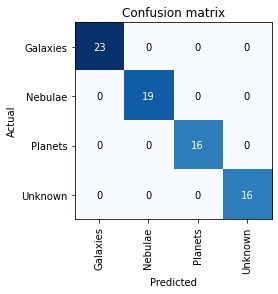

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Plot the image that are harder to the model to understand

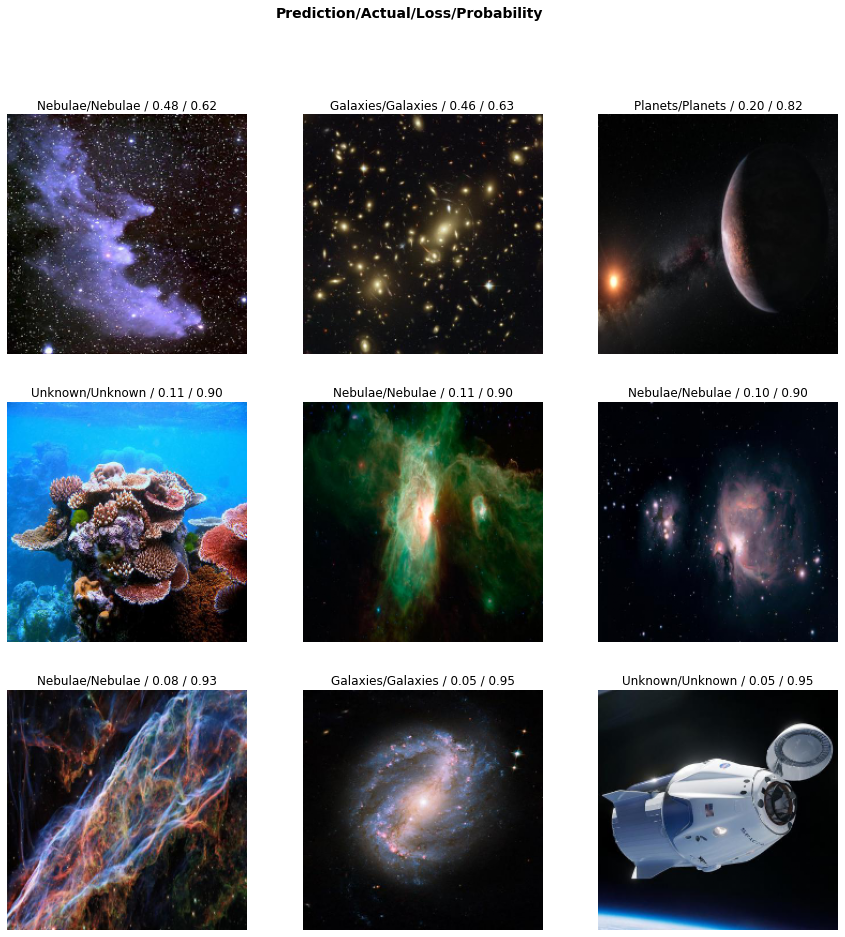

In [16]:
interp.plot_top_losses(9, figsize=(15,15))

Inference on test images

Planets
Confidence: 1.00


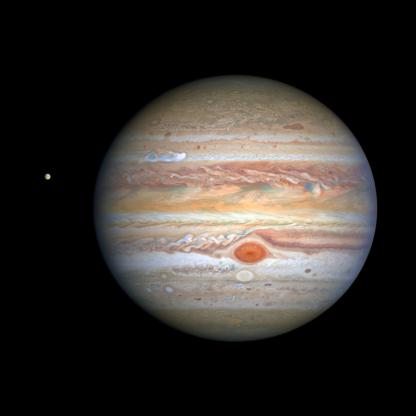



Planets
Confidence: 1.00


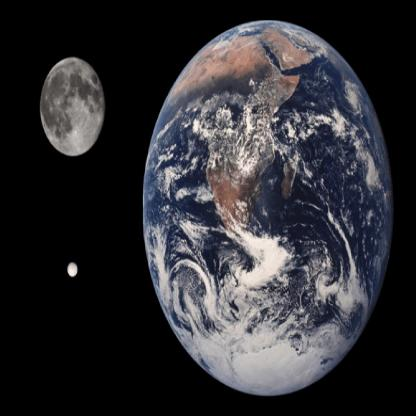



Planets
Confidence: 1.00


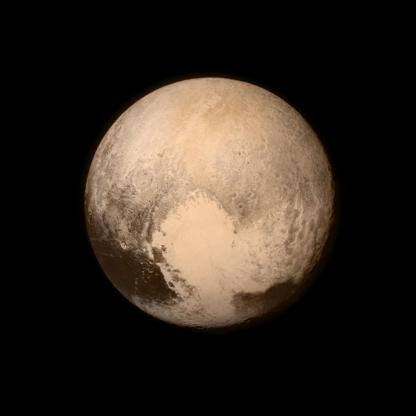



Planets
Confidence: 1.00


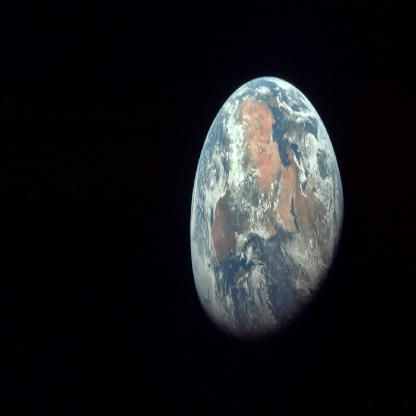



Planets
Confidence: 1.00


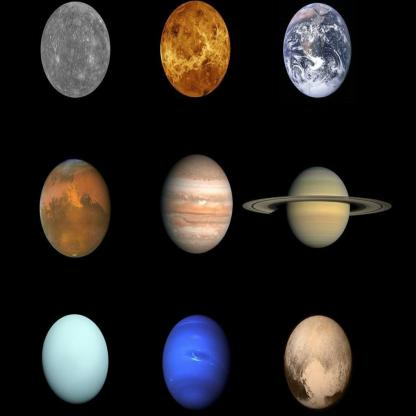



Planets
Confidence: 1.00


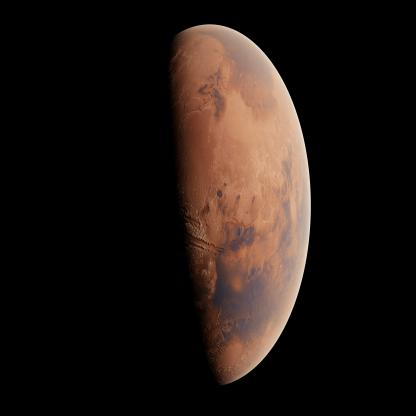



Planets
Confidence: 1.00


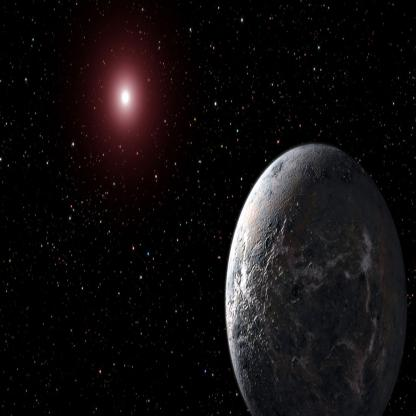



Planets
Confidence: 1.00


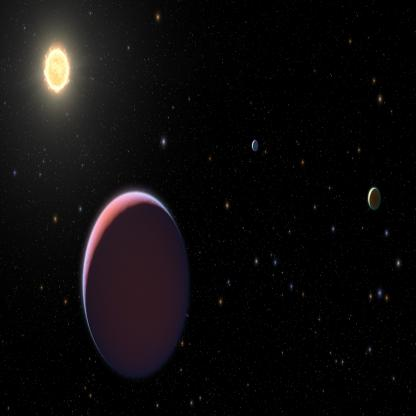



Planets
Confidence: 0.93


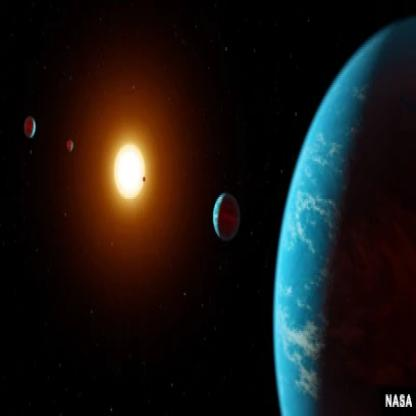



Planets
Confidence: 1.00


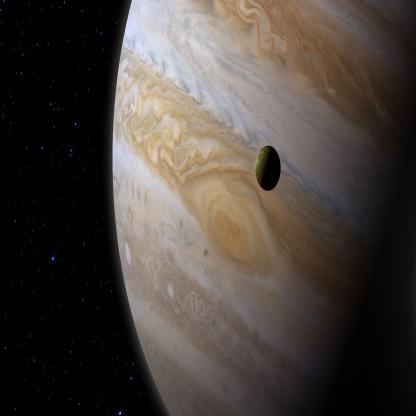



Planets
Confidence: 1.00


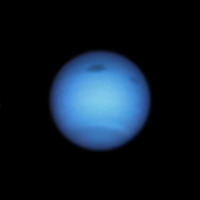



Planets
Confidence: 1.00


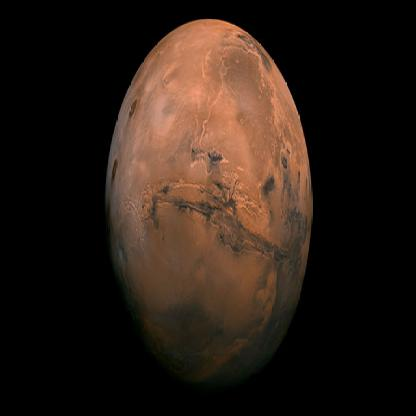



Planets
Confidence: 1.00


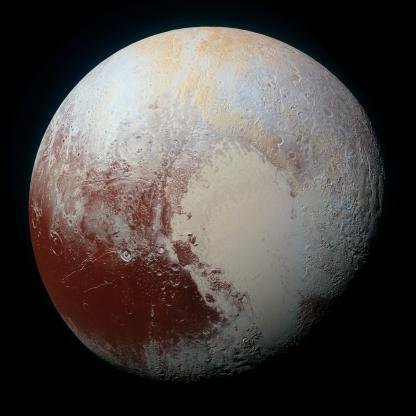



Unknown
Confidence: 1.00


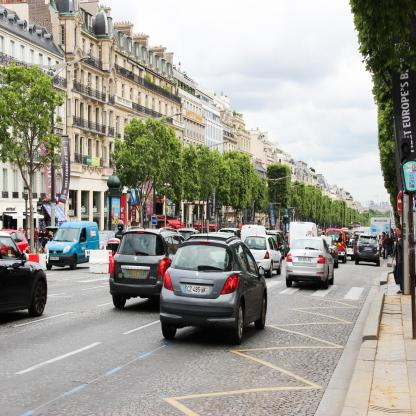



Unknown
Confidence: 0.60


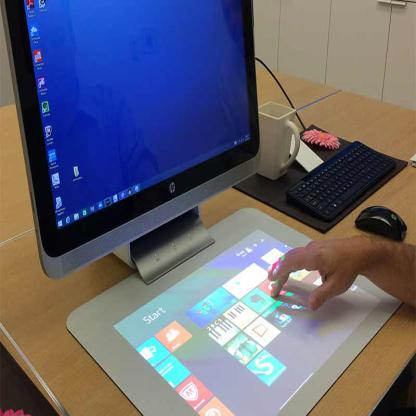



Unknown
Confidence: 1.00


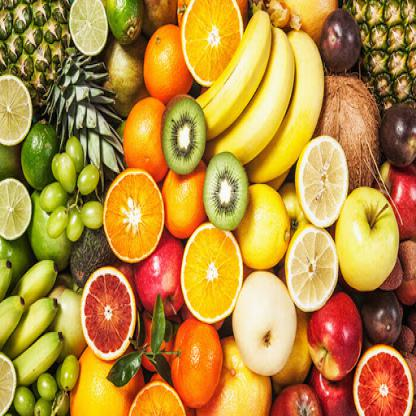



Unknown
Confidence: 1.00


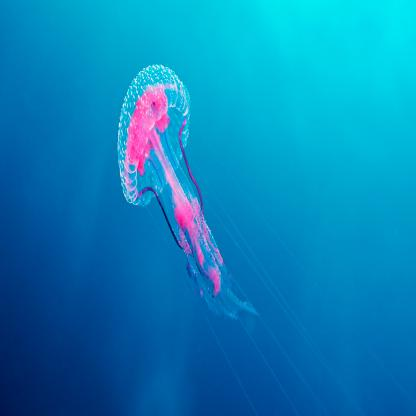



Unknown
Confidence: 1.00


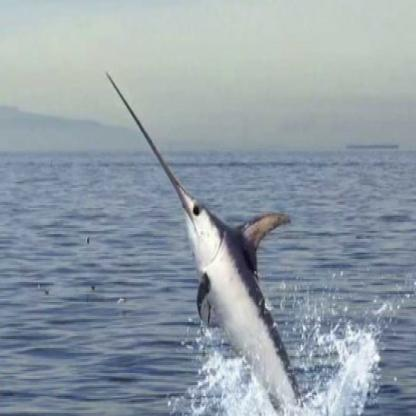



Unknown
Confidence: 1.00


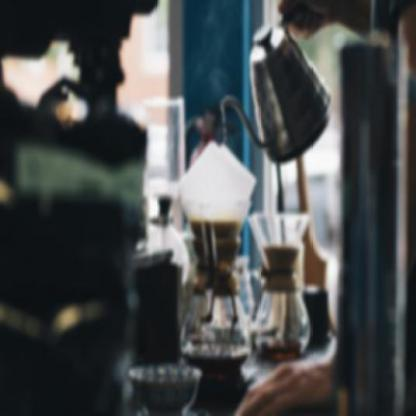



Unknown
Confidence: 1.00


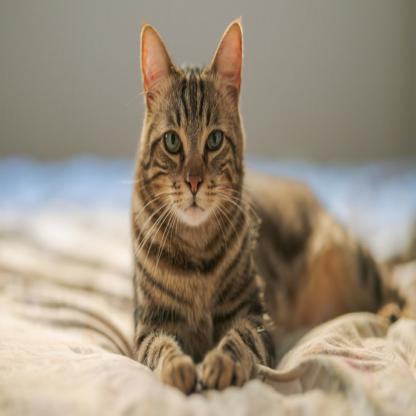



Unknown
Confidence: 1.00


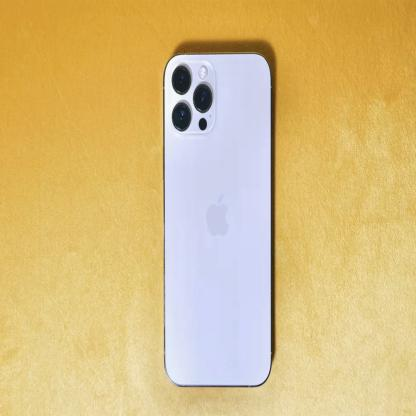



Unknown
Confidence: 0.80


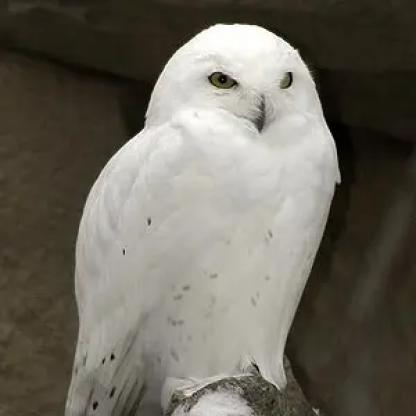



Unknown
Confidence: 1.00


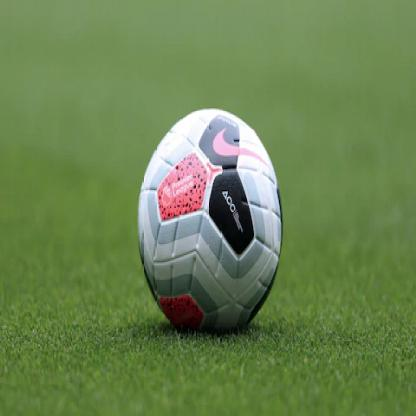



Unknown
Confidence: 1.00


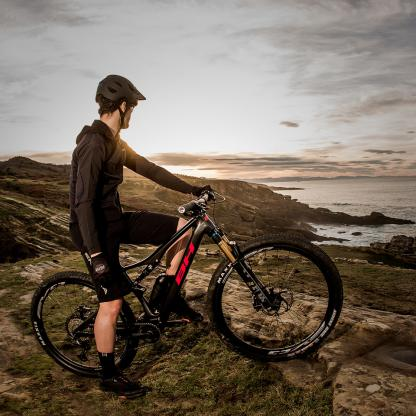



Unknown
Confidence: 1.00


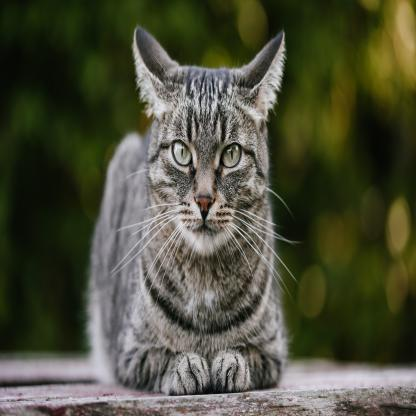



Unknown
Confidence: 1.00


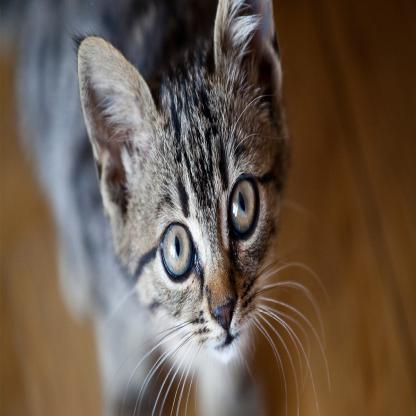



Galaxies
Confidence: 1.00


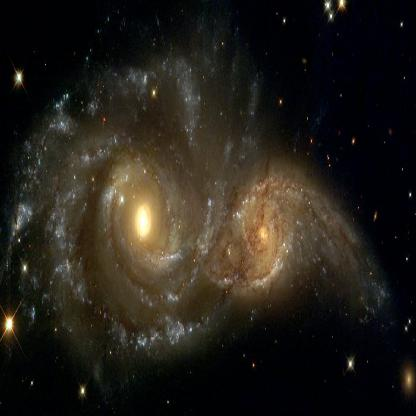



Galaxies
Confidence: 1.00


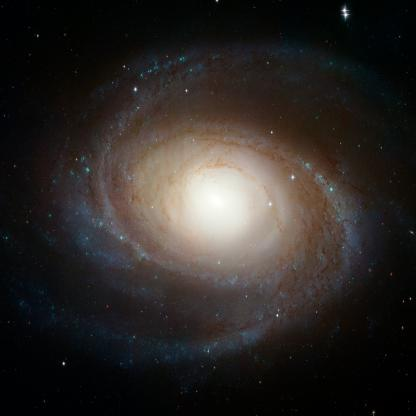



Galaxies
Confidence: 0.99


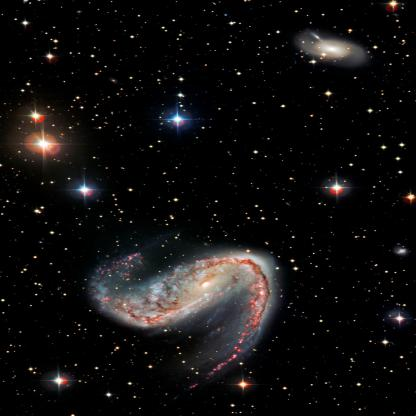



Galaxies
Confidence: 1.00


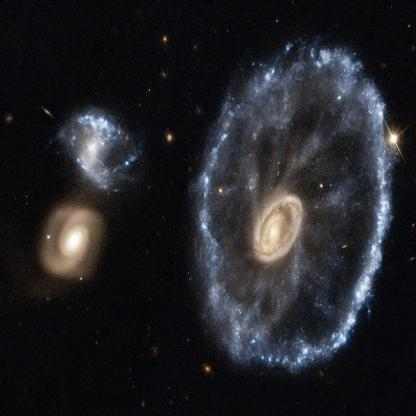



Galaxies
Confidence: 1.00


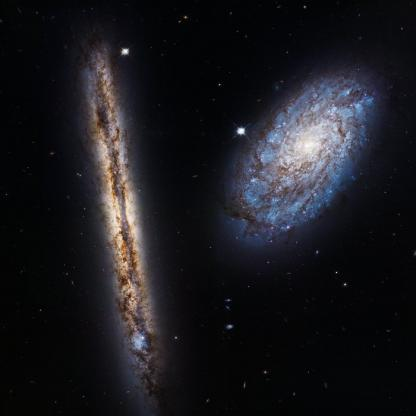



Galaxies
Confidence: 0.99


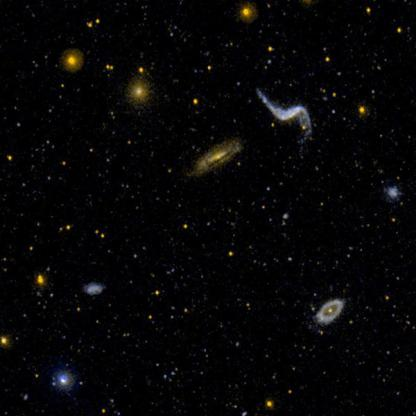



Galaxies
Confidence: 1.00


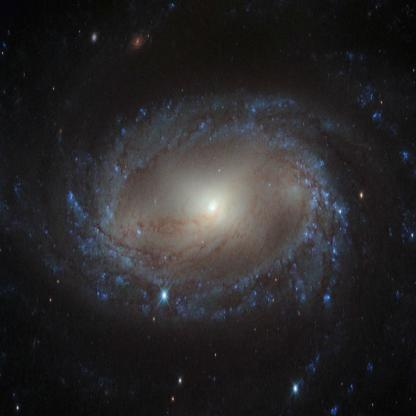



Galaxies
Confidence: 1.00


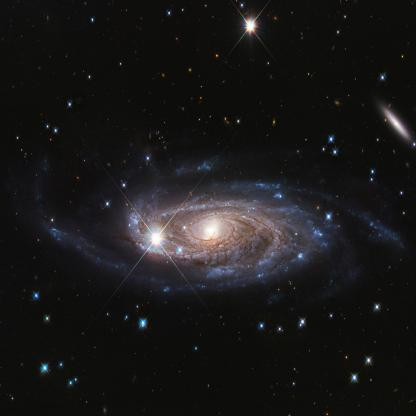



Galaxies
Confidence: 1.00


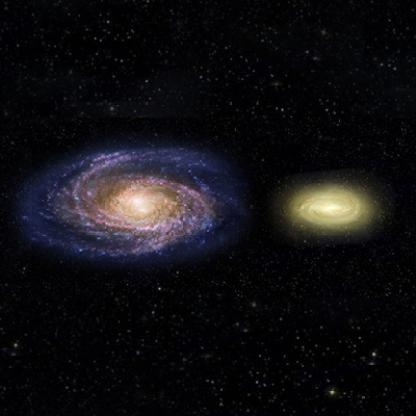



Galaxies
Confidence: 1.00


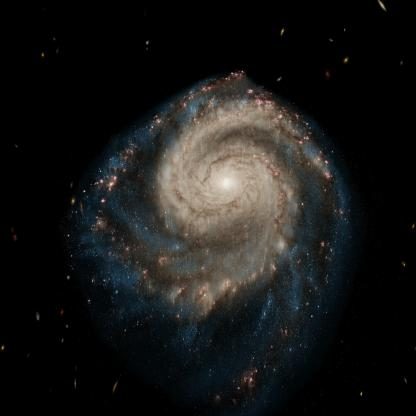



Galaxies
Confidence: 1.00


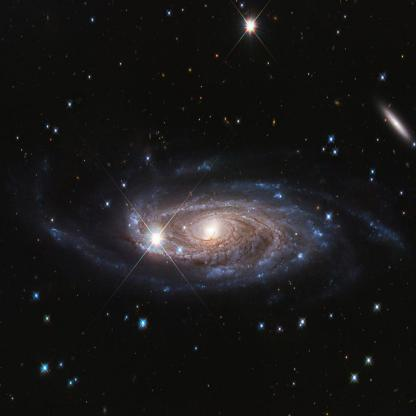



Galaxies
Confidence: 1.00


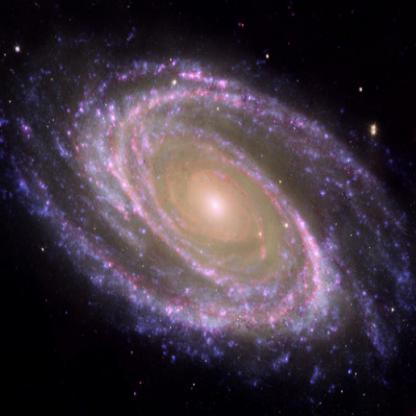



Galaxies
Confidence: 1.00


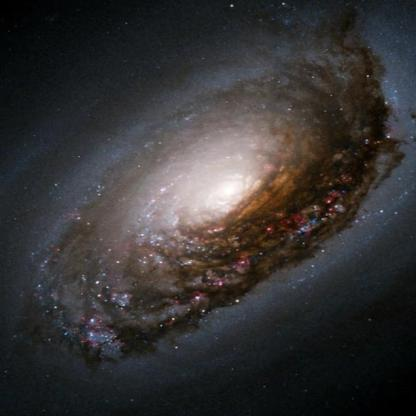



Nebulae
Confidence: 1.00


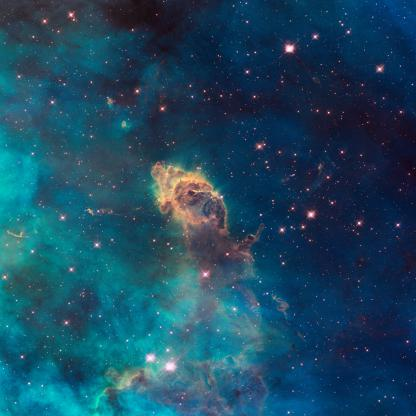



Nebulae
Confidence: 1.00


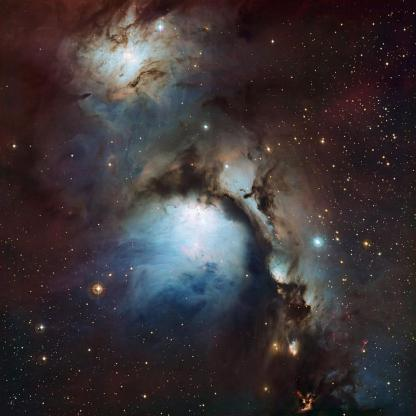



Nebulae
Confidence: 0.99


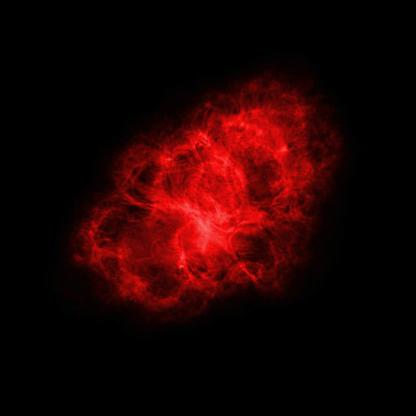



Nebulae
Confidence: 1.00


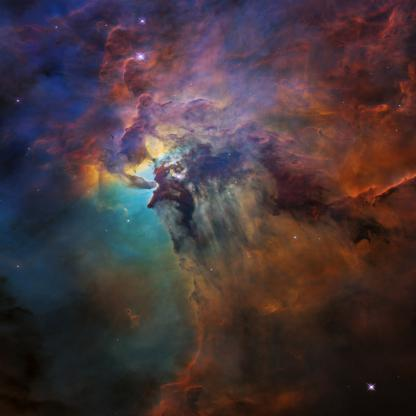



Nebulae
Confidence: 0.58


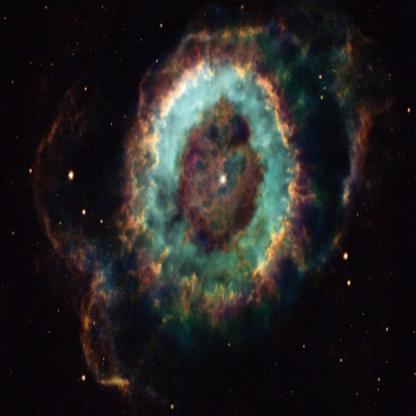



Nebulae
Confidence: 1.00


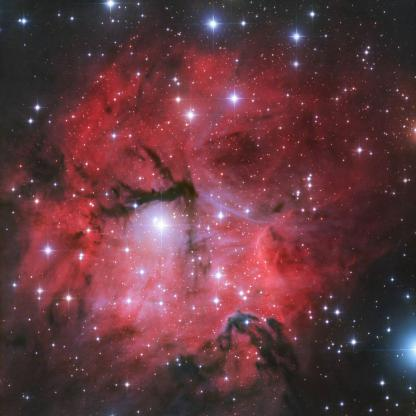



Nebulae
Confidence: 1.00


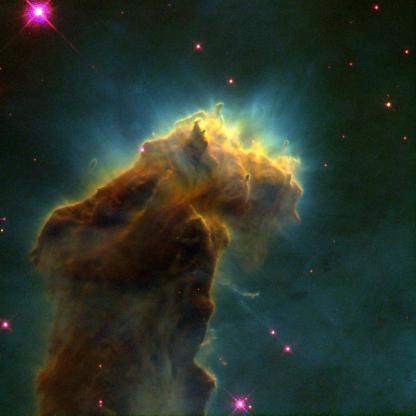



Nebulae
Confidence: 1.00


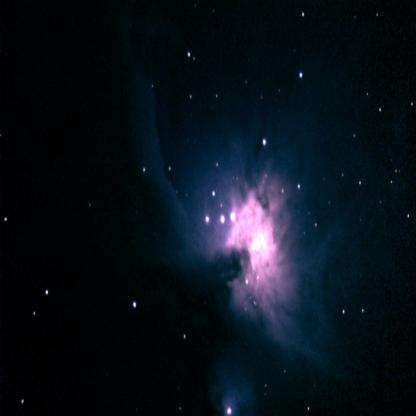



Nebulae
Confidence: 1.00


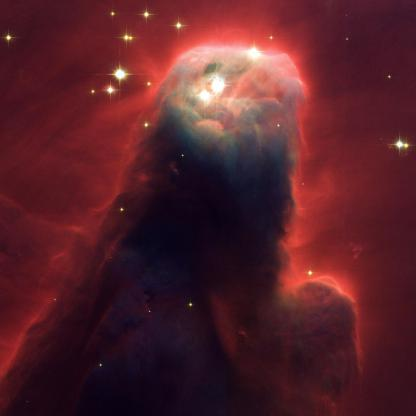



Nebulae
Confidence: 1.00


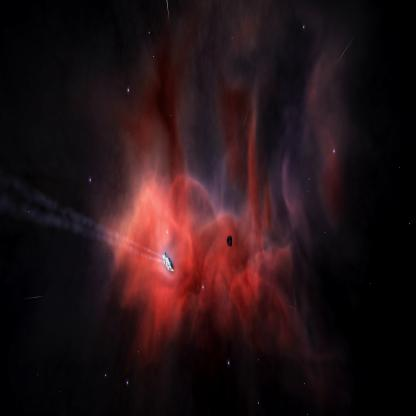



Nebulae
Confidence: 1.00


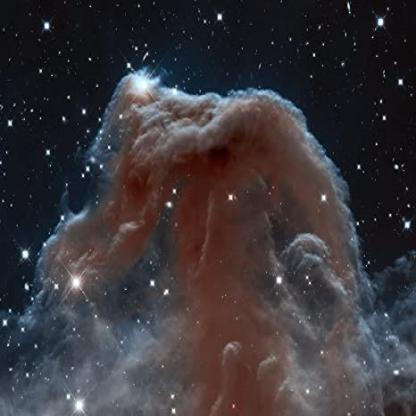



Nebulae
Confidence: 0.99


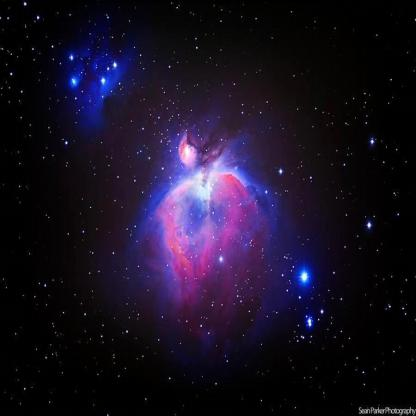



Nebulae
Confidence: 1.00


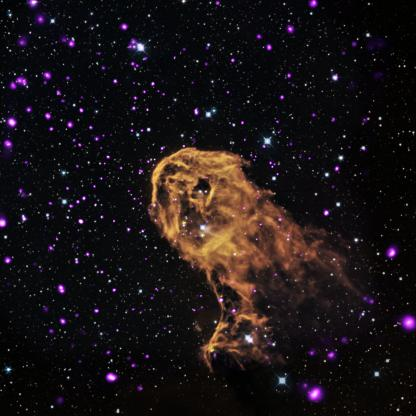

In [17]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/test/*/*.jpg'):
    img = open_image(imageName)
    prediction = learn.predict(img)
    print(prediction[0])
    confidence = torch.max(prediction[2])
    print("Confidence: " + "{:.2f}".format(confidence.item()))
    display(Image(filename=imageName))
    print("\n")